### ASTR 3300/5300-003: Astrostatistics
***N. Pol***
___

# Homework 3
### Due: Friday, Feb 14th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [25]:
!pip install numdifftools

In [1]:
import numdifftools as nd
H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
sigma_laplace = np.linalg.inv(H)**0.5

### this cell gives errors, laplace parameters not being defined.
### Are we supposed to modify this code cell as well? I will proceed without them for now...

NameError: name 'f_lnlaplace' is not defined

### Solution

Sample Mean: 3.917992034606056 Standard Error: 0.09481084100510954
Best-fit Mean (Gaussian): 3.917992034606056
Fisher Uncertainty Estimate: 0.09481084100510966


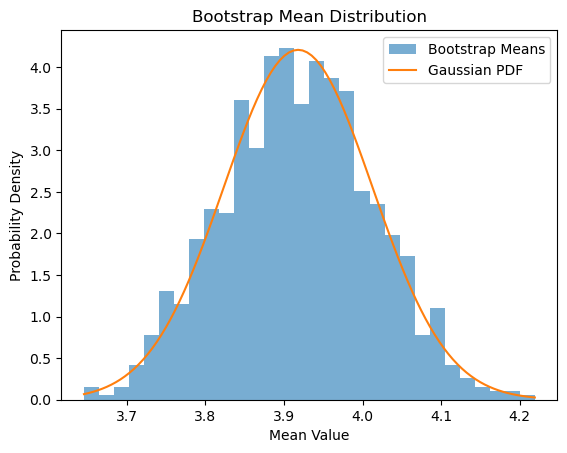

Best-fit Laplace Parameters: mu= 4.085564095662684 delta= 0.8822692333116826
AIC (Gaussian): 88.3250906929338 AIC (Laplace): 317.5778323531801
Gaussian model is preferred
Gaussian model is preferred


Range of mu: 4.085564095662684 to 4.085564095662684
Range of delta: 0.8822692333116826 to 0.8822692333116826


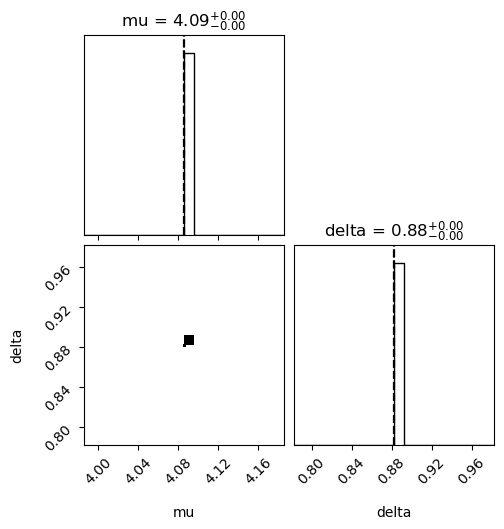

Fisher Uncertainties: mu= 0.10922538885791094 delta= 0.08822693426779783


/var/folders/h1/kqtnsfh94qlfjmw5vf4wkdkh0000gn/T/ipykernel_85798/3622041589.py:107: RuntimeWarning: invalid value encountered in sqrt
  sigma_laplace = np.sqrt(np.linalg.inv(H_laplace))


In [14]:
### imports
import numpy as np
import scipy.optimize as opt
import scipy.stats as stats
import matplotlib.pyplot as plt
import corner
import numdifftools as nd

### read in hw3_data
data = np.load('hw_data/hw3_data_1.npy')
measurements = data[:, 0]
uncertainties = data[:, 1]

### sample mean and standard error
weights = 1 / uncertainties**2
sample_mean = np.sum(weights * measurements) / np.sum(weights)
std_error = np.sqrt(1 / np.sum(weights))
print("Sample Mean:", sample_mean, "Standard Error:", std_error)

### log-likelihood function - heteroscedastic Gaussian
def ln_likelihood_gaussian(mu):
    return 0.5 * np.sum(((measurements - mu) / uncertainties) ** 2)

### minimise
result = opt.minimize(ln_likelihood_gaussian, x0=[sample_mean])
mu_gaussian_fit = result.x[0]
print("Best-fit Mean (Gaussian):", mu_gaussian_fit)

### Fisher uncertainty estimate
def neg_ln_likelihood(mu):
    return ln_likelihood_gaussian(mu[0])

H_gaussian = nd.Hessian(neg_ln_likelihood)([mu_gaussian_fit])
sigma_fisher_gaussian = np.sqrt(np.linalg.inv(H_gaussian))[0, 0]
print("Fisher Uncertainty Estimate:", sigma_fisher_gaussian)

### 1000 Bootstrap
def bootstrap(data, n_bootstrap=1000):
    indices = np.random.choice(len(data), size=(n_bootstrap, len(data)), replace=True)
    return data[indices]

bootstrap_samples = bootstrap(data)
bootstrap_means = [np.sum(1 / s[:, 1]**2 * s[:, 0]) / np.sum(1 / s[:, 1]**2) for s in bootstrap_samples]

### bootstrap mean distribution
plt.hist(bootstrap_means, bins=30, density=True, alpha=0.6, label='Bootstrap Means')
x = np.linspace(min(bootstrap_means), max(bootstrap_means), 100)
plt.plot(x, stats.norm.pdf(x, loc=sample_mean, scale=std_error), label='Gaussian PDF')
plt.legend()
plt.xlabel('Mean Value')
plt.ylabel('Probability Density')
plt.title('Bootstrap Mean Distribution')
plt.show()

### log-likelihood - Laplace distribution
def ln_likelihood_laplace(params):
    mu, delta = params
    return np.sum(np.abs(measurements - mu) / delta + np.log(2 * delta))

### minimise
result_laplace = opt.minimize(ln_likelihood_laplace, x0=[sample_mean, np.std(measurements)])
beta_laplace = result_laplace.x
print("Best-fit Laplace Parameters: mu=", beta_laplace[0], "delta=", beta_laplace[1])

### AIC values
def AIC(log_likelihood, num_params):
    return 2 * num_params - 2 * (-log_likelihood)

aic_gaussian = AIC(ln_likelihood_gaussian(mu_gaussian_fit), 1)
aic_laplace = AIC(ln_likelihood_laplace(beta_laplace), 2)
print("AIC (Gaussian):", aic_gaussian, "AIC (Laplace):", aic_laplace)
if aic_laplace < aic_gaussian:
    print("Laplace model is preferred")
else:
    print("Gaussian model is preferred")

### Bootstrap boo boo Bootstrap -> corner plot
### corner plot is modified with chatgpt

laplace_params = []
for s in bootstrap_samples:
    res = opt.minimize(ln_likelihood_laplace, x0=[sample_mean, np.std(measurements)])
    if res.success:
        laplace_params.append(res.x)
    else:
        print("Optimization failed for a bootstrap sample.")

if laplace_params:
    mu_bootstrap, delta_bootstrap = zip(*laplace_params)
    print("Range of mu:", min(mu_bootstrap),  "to", max(mu_bootstrap))
    print("Range of delta:", min(delta_bootstrap), "to", max(delta_bootstrap))
    
    corner.corner(
        np.column_stack((mu_bootstrap, delta_bootstrap)),
        labels=["mu", "delta"],
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        range=[(min(mu_bootstrap) - 0.1, max(mu_bootstrap) + 0.1),
               (min(delta_bootstrap) - 0.1, max(delta_bootstrap) + 0.1)]
    )
    plt.show()

### Fisher uncertainty for Laplace model
H_laplace = nd.Hessian(ln_likelihood_laplace)(beta_laplace)
sigma_laplace = np.sqrt(np.linalg.inv(H_laplace))
print("Fisher Uncertainties: mu=", sigma_laplace[0, 0], "delta=", sigma_laplace[1, 1])


In [8]:
sigma_laplace = np.sqrt(np.linalg.inv(H_laplace))
print(sigma_laplace)

[[0.10922539        nan]
 [       nan 0.08822693]]


/var/folders/h1/kqtnsfh94qlfjmw5vf4wkdkh0000gn/T/ipykernel_85798/3188124873.py:1: RuntimeWarning: invalid value encountered in sqrt
  sigma_laplace = np.sqrt(np.linalg.inv(H_laplace))
